In [2]:
#
import numpy as np 
import pandas as pd 
import random

# folder
import os
import glob

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [9]:
%%time

widths = []
heights = []
file_dir = '/Users/mintland/Downloads/chest_xray'
for set_ in datasets:
    for cat in categories:
        filelist = glob.glob(file_dir + '/' + set_ + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

Average image width: 1327.88
Average image height: 970.69
CPU times: user 899 ms, sys: 325 ms, total: 1.22 s
Wall time: 1.24 s


In [7]:
im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " + str(im_width))
print("image height: " + str(im_height))

image width: 132
image height: 97


In [10]:
%%time

data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob(file_dir + '/' + set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])
#
data_array = np.stack(data, axis=0)

CPU times: user 54.7 s, sys: 4.05 s, total: 58.8 s
Wall time: 1min 3s


In [11]:
print(data_array.shape)


(5856, 97, 132)


In [12]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

,count,%
PNEUMONIA,4273,73
NORMAL,1583,27


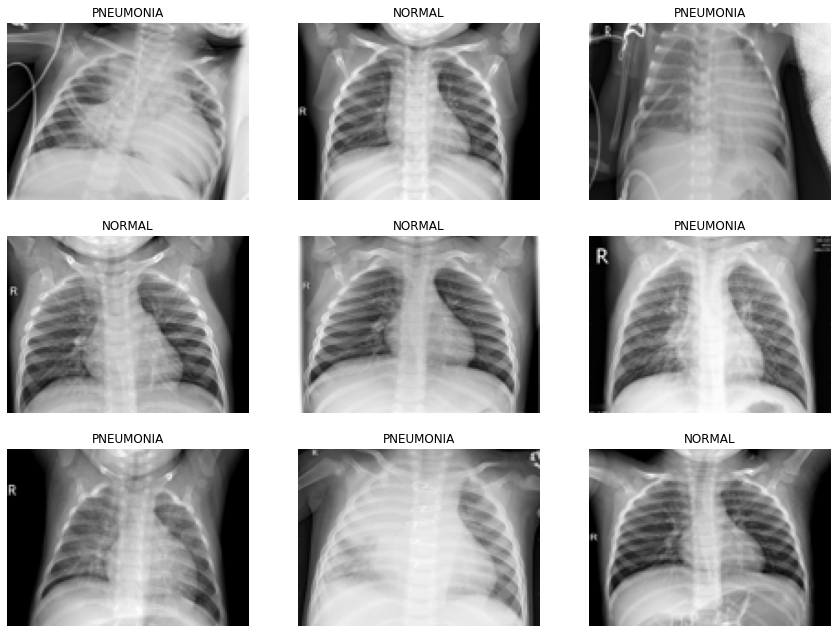

In [13]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)

for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [14]:
#train,test split

X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4684, 97, 132)
(1172, 97, 132)
(4684,)
(1172,)


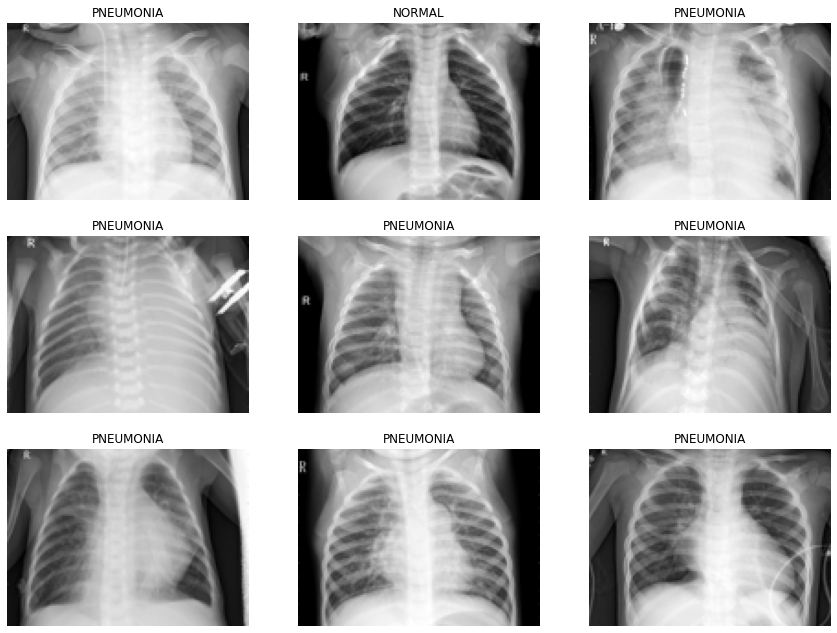

In [16]:
#normalizing data

fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off')
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image])

In [17]:
#target encoding

encoder = LabelEncoder()
y_train_cat = encoder.fit_transform(y_train)
y_test_cat = encoder.transform(y_test)

In [19]:
#reshape

X_train_norm = X_train_norm.reshape(-1, 97, 132, 1)
X_test_norm = X_test_norm.reshape(-1, 97, 132, 1)
print(X_train_norm.shape)
print(X_test_norm.shape)


(4684, 97, 132, 1)
(1172, 97, 132, 1)


In [20]:
#functional model

def CNN_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [25]:
model = CNN_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 97, 132, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 66, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 33, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 11, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11264)            

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics="accuracy"
              )

es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_norm, y_train_cat,
          batch_size=8,
          epochs=1000,
          validation_split=0.3,
          callbacks=[es]
          )

Epoch 1/1000
410/410 [==============================] - 30s 71ms/step - loss: 0.0711 - accuracy: 0.9762 - val_loss: 0.1362 - val_accuracy: 0.9602
Epoch 2/1000
410/410 [==============================] - 31s 76ms/step - loss: 0.0561 - accuracy: 0.9790 - val_loss: 0.2002 - val_accuracy: 0.9474
Epoch 3/1000
410/410 [==============================] - 29s 71ms/step - loss: 0.0465 - accuracy: 0.9811 - val_loss: 0.1452 - val_accuracy: 0.9531
Epoch 4/1000
410/410 [==============================] - 31s 75ms/step - loss: 0.0471 - accuracy: 0.9829 - val_loss: 0.1653 - val_accuracy: 0.9438
Epoch 5/1000
410/410 [==============================] - 33s 79ms/step - loss: 0.0323 - accuracy: 0.9875 - val_loss: 0.1795 - val_accuracy: 0.9538
Epoch 6/1000
410/410 [==============================] - 32s 79ms/step - loss: 0.0320 - accuracy: 0.9890 - val_loss: 0.1371 - val_accuracy: 0.9609
Epoch 7/1000
410/410 [==============================] - 34s 83ms/step - loss: 0.0238 - accuracy: 0.9915 - val_loss: 0.2160 -

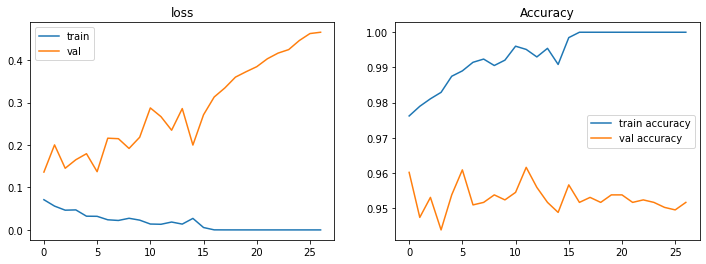

In [30]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

In [31]:
model.evaluate(X_test_norm, y_test_cat, verbose=0)

[0.18688032031059265, 0.9658703207969666]

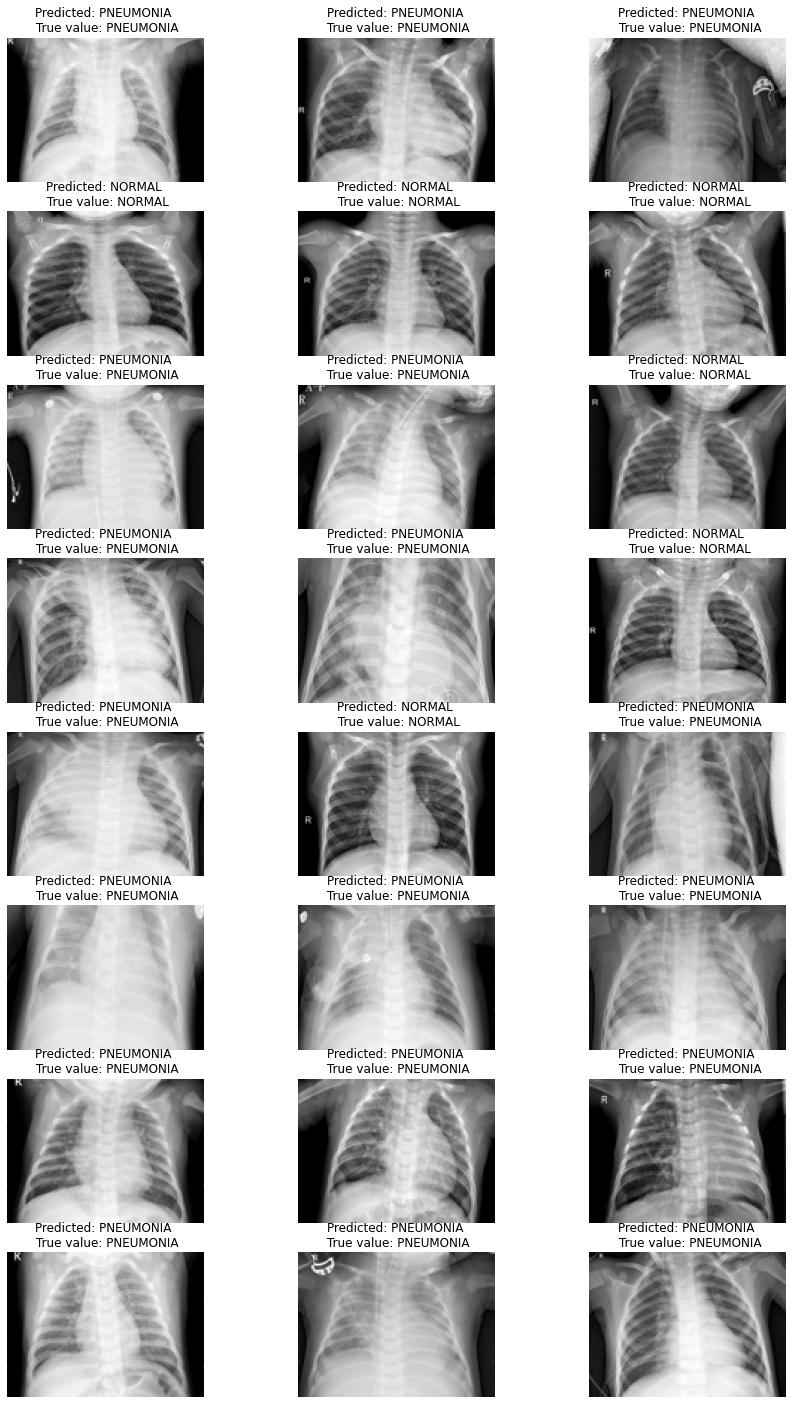

In [34]:
predictions = model.predict(X_test_norm)

fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 4)
#
for row in range(0, 8):
    for col in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " \n True value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test_norm[num_image]);
